# A TUTORIAL ON NEURAL NETWORK REGRESSION USING KERAS AND TENSORFLOW

by Sebastian T. Glavind, August, 2020

# Introduction

In this tutorial, we will consider how to define, train, and predict with a simple feed-forward neural network model using keras and tensorflow. First, we will consider a single-output regression. Second, we will consider how easy it is to extend the model formulation in the number of outputs. Third, we will see how to choose the hyperparameters using random search cross-validation. Note that random search is found to be superior to grid search when the model contains many hyperparameters. The interested reader is referred to the prominent textbook of Goodfellow et al. (2016) for an introduction to neural networks, and Geron (2019) for an excellent guide on their implementation.

We will consider a small data set in the tutorial, i.e. the Boston housing data set, so that training can be performed on a standard computer, thus regularization becomes extra important! In this regard, we will consider drop-out regularization.

***
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.

A. Geron, Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media, 2019.
***

# Prelude

In [1]:
import numpy as np
import scipy.stats as ss 
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.compose
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pickle
%matplotlib inline

In [2]:
# tensorflow 2.1
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Single-output Neural network


## Data set

In this tutorial, we will consider the Boston housing data set, see e.g. https://www.kaggle.com/c/boston-housing, which ships with `scikit-learn`. The data set reflect properties of houses in the suburbs of Boston and is  concerned with the modeling of house prices, see discription below.

In [3]:
BostonData = load_boston()
print(BostonData['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Define train and test data

In [4]:
Xraw, yraw = BostonData['data'], BostonData['target']
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xraw,yraw, train_size=.8, shuffle=True, 
                                                                  random_state=1)

### Scaling of inputs and outputs according to scale of training data

In [5]:
# Standardize features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Xtrain)
sXtrain = scaler.transform(Xtrain)
sXtest = scaler.transform(Xtest)

In [6]:
# Standardize outputs - no needed for single-outputs
scaler_y = sklearn.preprocessing.StandardScaler()
scaler_y.fit(ytrain.reshape(-1,1) )
sytrain = scaler_y.transform(ytrain.reshape(-1,1))
sytest = scaler_y.transform(ytest.reshape(-1,1))

## NN model

### Model definition

In this section, we will consider a neural network with two hidden layers of 32 units each and regularize the network training using drop-out. Other kinds of regularization are e.g. early stopping and batch normalization (commented out below), see e.g. Goodfellow et al. (2016) for a reference.

***
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.
***

In [7]:
NN_model = keras.models.Sequential()

# The Input Layer :
NN_model.add(Input(shape=(sXtrain.shape[1])))
# NN_model.add(Flatten(input_shape=[Xtrain.shape[1]]))
# NN_model.add(InputLayer(input_shape=Xtrain.shape[1]))
NN_model.add(Dropout(.2))
# NN_model.add(BatchNormalization())

# The Hidden Layers :
for layer in range(2):
        NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
        NN_model.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
______________________________________________________

### Model training

In [8]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]
# mcp = ModelCheckpoint("NNRreg_singleOut.hd5", save_best_only=True, period=5)
# csv = CSVLogger("NNRreg_singleOut.csv")
# es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
# lr = ReduceLROnPlateau(patience=10, verbose=1)
callbacks_list = []

In [9]:
tf.random.set_seed(123)
history = NN_model.fit(sXtrain, sytrain, epochs=200, batch_size=8, callbacks=callbacks_list)

Train on 404 samples
Epoch 1/200
404/404 [==============================] - 1s 1ms/sample - loss: 0.9726 - mse: 0.9726
Epoch 2/200
404/404 [==============================] - 0s 389us/sample - loss: 0.7945 - mse: 0.7945
Epoch 3/200
404/404 [==============================] - 0s 355us/sample - loss: 0.5479 - mse: 0.5479
Epoch 4/200
404/404 [==============================] - 0s 282us/sample - loss: 0.5323 - mse: 0.5323
Epoch 5/200
404/404 [==============================] - 0s 369us/sample - loss: 0.4177 - mse: 0.4177
Epoch 6/200
404/404 [==============================] - 0s 369us/sample - loss: 0.4612 - mse: 0.4612
Epoch 7/200
404/404 [==============================] - 0s 359us/sample - loss: 0.4514 - mse: 0.4514
Epoch 8/200
404/404 [==============================] - 0s 364us/sample - loss: 0.3835 - mse: 0.3835
Epoch 9/200
404/404 [==============================] - 0s 376us/sample - loss: 0.4672 - mse: 0.4672
Epoch 10/200
404/404 [==============================] - 0s 341us/sample - loss: 0

404/404 [==============================] - 0s 385us/sample - loss: 0.3856 - mse: 0.3856
Epoch 83/200
404/404 [==============================] - 0s 367us/sample - loss: 0.3336 - mse: 0.3336
Epoch 84/200
404/404 [==============================] - 0s 389us/sample - loss: 0.3241 - mse: 0.3241
Epoch 85/200
404/404 [==============================] - 0s 388us/sample - loss: 0.3771 - mse: 0.3771
Epoch 86/200
404/404 [==============================] - 0s 302us/sample - loss: 0.3703 - mse: 0.3703
Epoch 87/200
404/404 [==============================] - 0s 338us/sample - loss: 0.3871 - mse: 0.3871
Epoch 88/200
404/404 [==============================] - 0s 360us/sample - loss: 0.3681 - mse: 0.3681
Epoch 89/200
404/404 [==============================] - 0s 388us/sample - loss: 0.3676 - mse: 0.3676
Epoch 90/200
404/404 [==============================] - 0s 305us/sample - loss: 0.3334 - mse: 0.3334
Epoch 91/200
404/404 [==============================] - 0s 346us/sample - loss: 0.3585 - mse: 0.3585
Epo

404/404 [==============================] - 0s 395us/sample - loss: 0.3206 - mse: 0.3206
Epoch 163/200
404/404 [==============================] - 0s 340us/sample - loss: 0.3100 - mse: 0.3100
Epoch 164/200
404/404 [==============================] - 0s 375us/sample - loss: 0.3191 - mse: 0.3191
Epoch 165/200
404/404 [==============================] - 0s 368us/sample - loss: 0.3711 - mse: 0.3711
Epoch 166/200
404/404 [==============================] - 0s 360us/sample - loss: 0.3261 - mse: 0.3261
Epoch 167/200
404/404 [==============================] - 0s 346us/sample - loss: 0.3285 - mse: 0.3285
Epoch 168/200
404/404 [==============================] - 0s 360us/sample - loss: 0.3638 - mse: 0.3638
Epoch 169/200
404/404 [==============================] - 0s 352us/sample - loss: 0.3083 - mse: 0.3083
Epoch 170/200
404/404 [==============================] - 0s 309us/sample - loss: 0.3320 - mse: 0.3320
Epoch 171/200
404/404 [==============================] - 0s 329us/sample - loss: 0.2977 - mse: 0

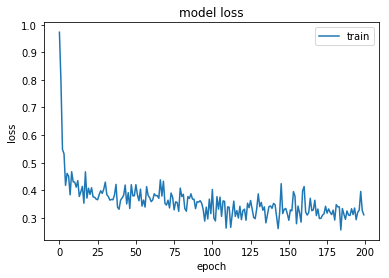

In [10]:
# print(history.history.keys())
# "Loss"
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right');

### Model evaluation

In [11]:
print('Training data')
NN_model.evaluate(sXtrain, sytrain)
print('Test data')
NN_model.evaluate(sXtest, sytest);
pred_test = NN_model.predict(sXtest)

Training data
404/404 [==============================] - 0s 203us/sample - loss: 0.2077 - mse: 0.2077
Test data
102/102 [==============================] - 0s 96us/sample - loss: 0.2634 - mse: 0.2634


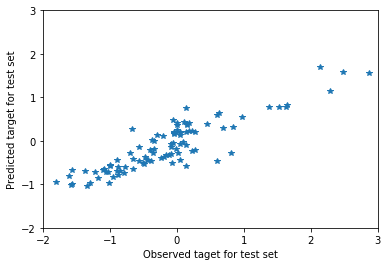

In [12]:
plt.plot(sytest, pred_test,'*');
plt.xlabel('Observed taget for test set')
plt.ylabel('Predicted target for test set');
plt.axis([-2, 3, -2, 3]);

# Multi-output Neural network

## Data set

In this section, we will define a multi-output regression problem using the Boston data set by modeling the tax rate per $10,000 along with the housing price using the remaining variables as predictors.

In [13]:
Xraw2 = Xraw.copy();
Xraw2 = np.delete(Xraw2,obj=9,axis=1)
yraw2 = yraw.copy()
yraw2 = np.vstack((yraw2, Xraw[:,9])).T

### Define train and test data

In [14]:
Xtrain2, Xtest2, ytrain2, ytest2 = sklearn.model_selection.train_test_split(Xraw2, yraw2, train_size=.8, 
                                                                            shuffle=True, random_state=1)

### Scaling of inputs and outputs according to scale of training data

In [15]:
# Standardize features
scaler2 = sklearn.preprocessing.StandardScaler()
scaler2.fit(Xtrain2)
sXtrain2 = scaler2.transform(Xtrain2)
sXtest2 = scaler2.transform(Xtest2)

In [16]:
# Standardize outputs - stabelizes training when considering multiple outputs on different scales
scaler_y2 = sklearn.preprocessing.StandardScaler()
scaler_y2.fit(ytrain2)
sytrain2 = scaler_y2.transform(ytrain2)
sytest2 = scaler_y2.transform(ytest2)

## NN model

### Model definition

In this section, we will again consider a neural network with two hidden layers of 32 units each and regularize the network training using drop-out.

In [17]:
NN_model2 = keras.models.Sequential()

# The Input Layer :
NN_model2.add(Input(shape=(sXtrain2.shape[1])))
NN_model.add(Dropout(.2))
# NN_model.add(BatchNormalization())

# The Hidden Layers :
for layer in range(2):
        NN_model2.add(Dense(32, kernel_initializer='normal',activation='relu'))
        NN_model2.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

# The Output Layer :
NN_model2.add(Dense(sytrain2.shape[1], kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

NN_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                416       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


### Model training

In [18]:
tf.random.set_seed(123)
history2 = NN_model2.fit(sXtrain2, sytrain2, epochs=200, batch_size=8, callbacks=callbacks_list)

Train on 404 samples
Epoch 1/200
404/404 [==============================] - 0s 1ms/sample - loss: 0.9646 - mse: 0.9646
Epoch 2/200
404/404 [==============================] - 0s 375us/sample - loss: 0.7457 - mse: 0.7457
Epoch 3/200
404/404 [==============================] - 0s 385us/sample - loss: 0.5110 - mse: 0.5110
Epoch 4/200
404/404 [==============================] - 0s 354us/sample - loss: 0.4513 - mse: 0.4513
Epoch 5/200
404/404 [==============================] - 0s 366us/sample - loss: 0.4517 - mse: 0.4517
Epoch 6/200
404/404 [==============================] - 0s 378us/sample - loss: 0.3811 - mse: 0.3811
Epoch 7/200
404/404 [==============================] - 0s 386us/sample - loss: 0.3604 - mse: 0.3604
Epoch 8/200
404/404 [==============================] - 0s 352us/sample - loss: 0.3799 - mse: 0.3799
Epoch 9/200
404/404 [==============================] - 0s 327us/sample - loss: 0.3572 - mse: 0.3572
Epoch 10/200
404/404 [==============================] - 0s 332us/sample - loss: 0

404/404 [==============================] - 0s 377us/sample - loss: 0.2441 - mse: 0.2441
Epoch 83/200
404/404 [==============================] - 0s 310us/sample - loss: 0.2627 - mse: 0.2627
Epoch 84/200
404/404 [==============================] - 0s 331us/sample - loss: 0.2811 - mse: 0.2811
Epoch 85/200
404/404 [==============================] - 0s 382us/sample - loss: 0.2680 - mse: 0.2680
Epoch 86/200
404/404 [==============================] - 0s 367us/sample - loss: 0.2568 - mse: 0.2568
Epoch 87/200
404/404 [==============================] - 0s 362us/sample - loss: 0.2776 - mse: 0.2776
Epoch 88/200
404/404 [==============================] - 0s 376us/sample - loss: 0.2768 - mse: 0.2768
Epoch 89/200
404/404 [==============================] - 0s 348us/sample - loss: 0.2400 - mse: 0.2400
Epoch 90/200
404/404 [==============================] - 0s 351us/sample - loss: 0.2452 - mse: 0.2452
Epoch 91/200
404/404 [==============================] - 0s 348us/sample - loss: 0.2455 - mse: 0.2455
Epo

404/404 [==============================] - 0s 338us/sample - loss: 0.2390 - mse: 0.2390
Epoch 163/200
404/404 [==============================] - 0s 373us/sample - loss: 0.2218 - mse: 0.2218
Epoch 164/200
404/404 [==============================] - 0s 368us/sample - loss: 0.2581 - mse: 0.2581
Epoch 165/200
404/404 [==============================] - 0s 318us/sample - loss: 0.2122 - mse: 0.2122
Epoch 166/200
404/404 [==============================] - 0s 350us/sample - loss: 0.2442 - mse: 0.2442
Epoch 167/200
404/404 [==============================] - 0s 380us/sample - loss: 0.2357 - mse: 0.2357
Epoch 168/200
404/404 [==============================] - 0s 296us/sample - loss: 0.2441 - mse: 0.2441
Epoch 169/200
404/404 [==============================] - 0s 336us/sample - loss: 0.2350 - mse: 0.2350
Epoch 170/200
404/404 [==============================] - 0s 367us/sample - loss: 0.2702 - mse: 0.2702
Epoch 171/200
404/404 [==============================] - 0s 375us/sample - loss: 0.2390 - mse: 0

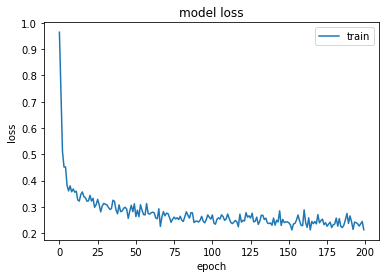

In [19]:
# print(history.history.keys())
# "Loss"
plt.figure()
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right');

### Model evaluation

In [20]:
print('Training data')
NN_model2.evaluate(sXtrain2, sytrain2)
print('Test data')
NN_model2.evaluate(sXtest2, sytest2)
# predictions
pred_test2 = NN_model2.predict(sXtest2)

Training data
404/404 [==============================] - 0s 217us/sample - loss: 0.1062 - mse: 0.1062
Test data
102/102 [==============================] - 0s 98us/sample - loss: 0.1304 - mse: 0.1304


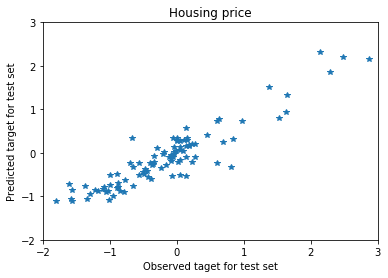

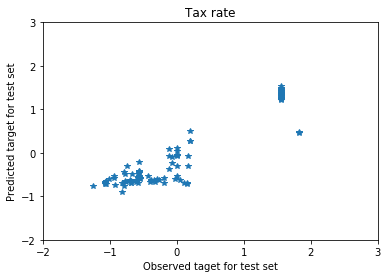

In [21]:
plt.figure()
plt.plot(sytest2[:,0], pred_test2[:,0],'*');
plt.xlabel('Observed taget for test set')
plt.ylabel('Predicted target for test set');
plt.title('Housing price');
plt.axis([-2, 3, -2, 3]);

plt.figure()
plt.plot(sytest2[:,1], pred_test2[:,1],'*');
plt.xlabel('Observed taget for test set')
plt.ylabel('Predicted target for test set');
plt.title('Tax rate');
plt.axis([-2, 3, -2, 3]);

# Hyperparameter optimization

It gets tedious to find an "optimal" combination of the hyperparameters by hand, so in this section, we will explore how we can automate this process.

## Random search

In this section, we will use the random search implementation `RandomizedSearchCV` of the `sklearn` package to select a setting for the model hyperparameters, which we will take to be the number of hidden layers and neurons.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

First, we define a model builder function for `RandomizedSearchCV`;

In [23]:
def model_opt(n_hidden=1, n_units=32, input_shape=[12]):
    model = keras.models.Sequential()

    # The Input Layer :
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(.2))
#     NN_model.add(BatchNormalization())

    # The Hidden Layers :
    for layer in range(n_hidden):
        model.add(Dense(n_units, kernel_initializer='normal',activation='relu'))
        model.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

    # The Output Layer :
    model.add(Dense(2, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return(model)

Second, we wrap the model for use with `sklearn` using the `KerasRegressor` function, define the search space, and perform the optimization. Note that this is a little time consuming even for this small example, and thus the optimization is pre-run, saved and loaded below (uncomment the content of the following two cells to re-run the optimization). Note that the splitting of the test data in this case, i.e. defining a validation and test set, only accounts for early-stopping, as the validation error in `RandomizedSearchCV` is evaluated using k-fold cross-validation.

In [24]:
# estimators = []
# estimators.append(( 'scaler', sklearn.preprocessing.StandardScaler() ))
# estimators.append(( 'mlp', keras.wrappers.scikit_learn.KerasRegressor(model_opt) ))
# pipeline = Pipeline(estimators)

# pipe_y = sklearn.compose.TransformedTargetRegressor(regressor=pipeline, 
#                                                     transformer=sklearn.preprocessing.StandardScaler() )

# hyper_param = {'regressor__mlp__n_hidden': (1,2,3,4),
#                'regressor__mlp__n_units': (32, 64, 128, 256, 512)
#               }

# rsCV = RandomizedSearchCV(pipe_y, hyper_param, n_iter=10, cv=5, refit=True, random_state=12345)
# rsCV.fit(Xtrain2, ytrain2, mlp__epochs=200, mlp__batch_size=8, mlp__callbacks=callbacks_list);

In [25]:
# print(rsCV.best_params_)
# optScaler2 = rsCV.best_estimator_.regressor_['scaler'] # collect input scaler
# optModel2 = rsCV.best_estimator_.regressor_['mlp'].model # collect model
# optTrans2 = rsCV.best_estimator_.transformer_ # collect out scaler (transformer)
# optModel2.save('NNReg_optModel2.h5')  # creates a HDF5 file 'NNReg_optModel2.h5'
# pickle.dump((optScaler2, optTrans2), open('NNReg_scalers2.pkl', 'wb'))

In [26]:
optScaler2, optTrans2 = pickle.load(open('NNReg_scalers2.pkl', 'rb'))
optModel2 = keras.models.load_model('NNReg_optModel2.h5')
optModel2.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_186 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 256)               3328      
_________________________________________________________________
dropout_187 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_188 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 2)                 514       
Total params: 69,634
Trainable params: 69,634
Non-trainable params: 0
_________________________________________________

### Model evaluation

In [27]:
print('Training data')
sXtrain2opt = optScaler2.transform(Xtrain2) # same as sXtrain2 (scaler trained on full training set in both cases)
sytrain2opt = optTrans2.transform(ytrain2) # same as sytrain2 (scaler trained on full training set in both cases)
optModel2.evaluate(sXtrain2opt, sytrain2opt)
print('Test data')
sXtest2opt = optScaler2.transform(Xtest2) # same as sXtest2 (scaler trained on full training set in both cases)
sytest2opt = optTrans2.transform(ytest2) # same as sytest2 (scaler trained on full training set in both cases)
optModel2.evaluate(sXtest2opt, sytest2opt)
pred_test2opt = optModel2.predict(sXtest2opt)

Training data
404/404 [==============================] - 0s 200us/sample - loss: 0.1075 - mse: 0.1075
Test data
102/102 [==============================] - 0s 142us/sample - loss: 0.1530 - mse: 0.1530


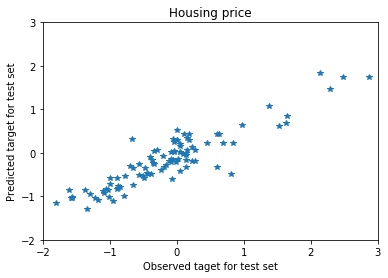

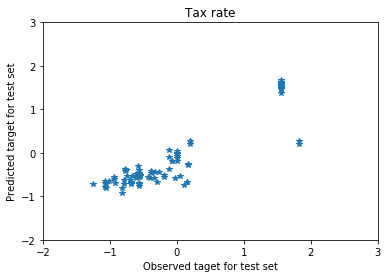

In [28]:
plt.figure()
plt.plot(sytest2opt[:,0], pred_test2opt[:,0],'*');
plt.xlabel('Observed taget for test set')
plt.ylabel('Predicted target for test set');
plt.title('Housing price');
plt.axis([-2, 3, -2, 3]);

plt.figure()
plt.plot(sytest2opt[:,1], pred_test2opt[:,1],'*');
plt.xlabel('Observed taget for test set')
plt.ylabel('Predicted target for test set');
plt.title('Tax rate');
plt.axis([-2, 3, -2, 3]);

This model captures the general tendency in the data, but if we were to continue this iterative process, we would try out a smaller range of possible network architectures around the current best network, e.g. NNs with two hidden layers and range(128,512,8) neurons. 